In [10]:
!pip install nltk textblob transformers torch pandas matplotlib seaborn wordcloud


In [11]:
# ADVANCED CUSTOMER FEEDBACK ANALYSIS (TextBlob vs VADER vs BERT)
# Import libraries
import pandas as pd
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

# Download NLTK stopwords (for cleaning)
nltk.download('stopwords')
nltk.download('vader_lexicon')


# Upload your feedback CSV file
uploaded = files.upload()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Saving redmi6.csv to redmi6 (1).csv


In [12]:
# Load the file
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name, encoding='latin1')
df.head()

,Review Title,Customer name,Rating,Date,Category,Comments,Useful
0,Another Midrange killer Smartphone by Xiaomi,Rishikumar Thakur,4.0 out of 5 stars,on 1 October 2018,Display,Another Midrange killer Smartphone by Xiaomi\n...,
1,vry small size mobile,Raza ji,3.0 out of 5 stars,on 15 September 2018,Others,All ok but vry small size mobile,7 people found this helpful
2,Full display not working in all application.,Vaibhav Patel,3.0 out of 5 stars,on 18 September 2018,Others,Quite good,7 people found this helpful
3,Value for Money,Amazon Customer,5.0 out of 5 stars,on 28 September 2018,Display,Redmi has always have been the the king of bud...,2 people found this helpful
4,Not worth for the money,Sudhakaran Wadakkancheri,2.0 out of 5 stars,on 18 September 2018,Others,worst product from MI. I am a hardcore fan of ...,6 people found this helpful


In [13]:
df.rename(columns={
    'Review Title':'review_title',
    'Customer name':'customer_name',
    'Rating':'rating',
    'Date':'date',
    'Category':'category',
    'Comments':'comments',
    'Useful':'useful'
}, inplace=True)


In [14]:
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r'[^a-z\s]', '', t)
    return t

df['clean_comments'] = df['comments'].apply(clean_text)


In [15]:
# 1. TextBlob Sentiment
def textblob_sentiment(t):
    score = TextBlob(t).sentiment.polarity
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    return "neutral"

df['textblob_sentiment'] = df['clean_comments'].apply(textblob_sentiment)

In [16]:
# 2. VADER Sentiment
sia = SentimentIntensityAnalyzer()

def vader_sentiment(t):
    score = sia.polarity_scores(t)['compound']
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    return 'neutral'

df['vader_sentiment'] = df['comments'].astype(str).apply(vader_sentiment)



In [19]:
# 3. BERT Sentiment
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

labels = ["negative", "neutral", "positive"]

def bert_sentiment(t):
    # Add max_length to explicitly truncate long sequences to 512 tokens
    inputs = tokenizer(t, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    score = torch.softmax(outputs.logits, dim=1)
    return labels[torch.argmax(score)]

df['bert_sentiment'] = df['comments'].astype(str).apply(bert_sentiment)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


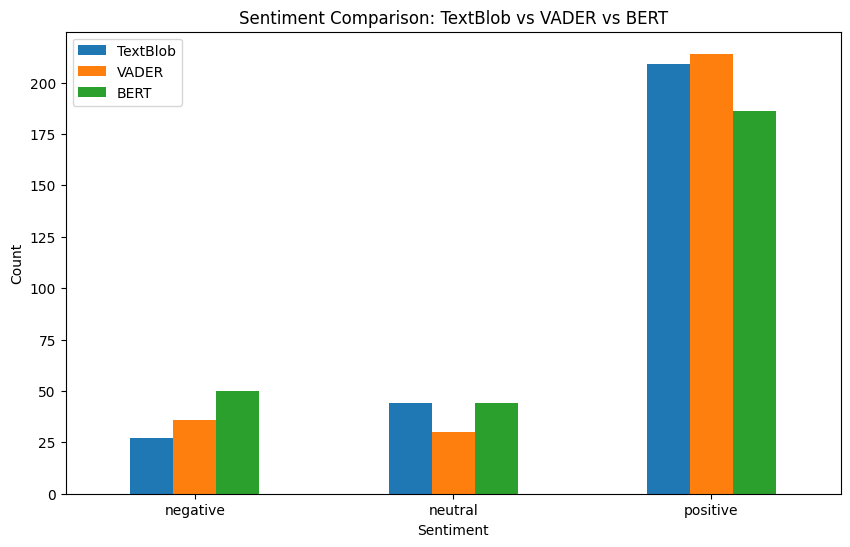

In [26]:

#Grouped Bar Chart — TextBlob vs VADER vs BERT Shows how all three models compare on sentiment counts.
import matplotlib.pyplot as plt
import pandas as pd

model_counts = pd.DataFrame({
    "TextBlob": df['textblob_sentiment'].value_counts(),
    "VADER": df['vader_sentiment'].value_counts(),
    "BERT": df['bert_sentiment'].value_counts()
}).fillna(0)

model_counts.plot(kind='bar', figsize=(10,6))
plt.title("Sentiment Comparison: TextBlob vs VADER vs BERT")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()



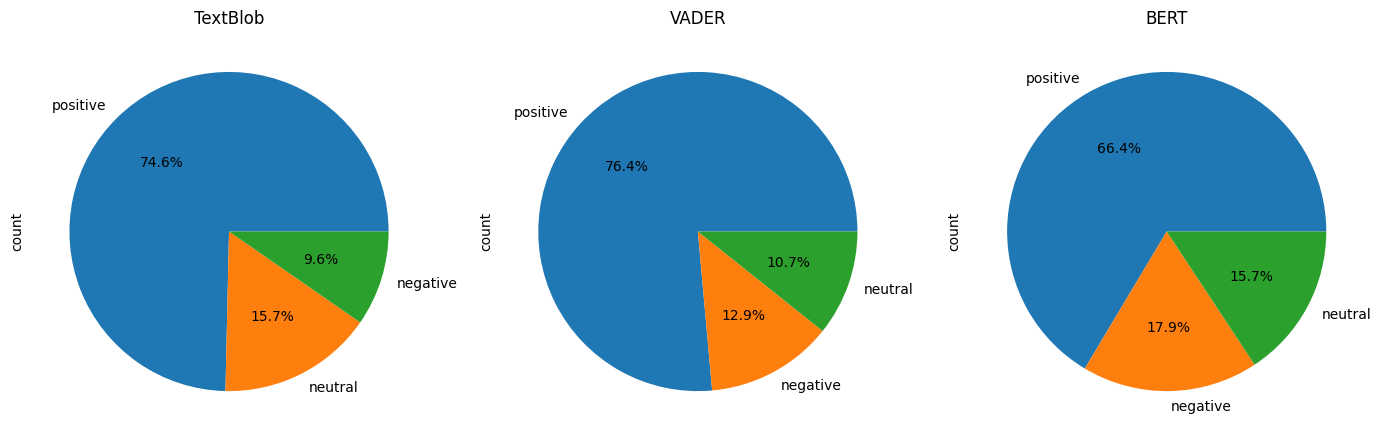

In [27]:
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
df['textblob_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("TextBlob")

plt.subplot(1,3,2)
df['vader_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("VADER")

plt.subplot(1,3,3)
df['bert_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("BERT")

plt.tight_layout()
plt.show()


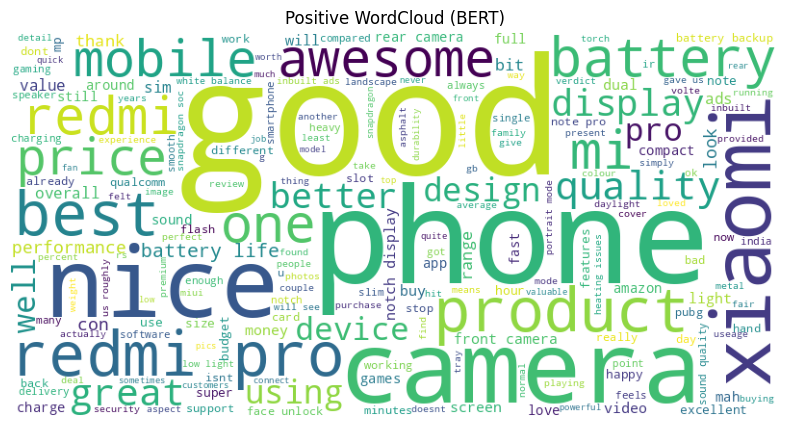

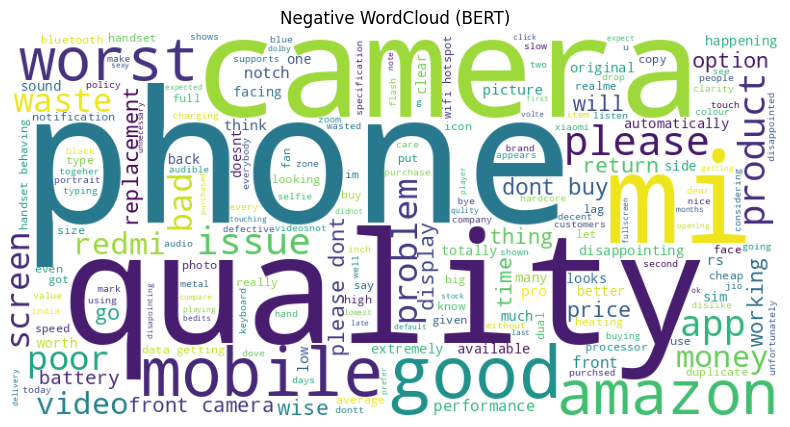

In [25]:
#Positive
pos_text = " ".join(df[df['bert_sentiment']=='positive']['clean_comments'])
wc = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.title("Positive WordCloud (BERT)")
plt.show()

#Negative
neg_text = " ".join(df[df['bert_sentiment']=='negative']['clean_comments'])
wc = WordCloud(width=800, height=400, background_color='white').generate(neg_text)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.title("Negative WordCloud (BERT)")
plt.show()

In [30]:
#If someone wants to test a single sentence:
def analyze_sentence(sentence):
    tb = textblob_sentiment(sentence)
    vd = vader_sentiment(sentence)
    br = bert_sentiment(sentence)
    print(f"Sentence: {sentence}")
    print(f"TextBlob: {tb}, VADER: {vd}, BERT: {br}")

# Example
analyze_sentence("I love this product!")


Sentence: I love this product!
TextBlob: positive, VADER: positive, BERT: positive
